# Ajuste fino de modelos para traducción
## Machine Translation



En este notebook vamos a usar diversos modelos para la traducción automática entre idiomas y vamos a realizar un ajuste fino

In [1]:
from huggingface_hub import login
token = ""
print("Hugging Face logging")
login(token)

Hugging Face logging


In [2]:
import torch
device_setup = "cuda" if torch.cuda.is_available() else "cpu"
print("Using: ", device_setup)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Using:  cpu


Para simplificar el uso de los distintos modelos hemos creado el fichero `./libs/mts` que contiene las clases `MarianMT` y `T5MT` del notebook anterior, así como las funciones `load_pretrained_t5` y `load_pretrained_marian_mt`.

In [3]:
from libs.mts import T5MT, MarianMT
from libs.mts import load_pretrained_t5, load_pretrained_marian_mt

## Modelos refinados inglés-español

Cuando se usan modelos, otra opción, es utilizar un modelo preentrenado y refinarlos con un nuevo conjunto de entrenamiento. Para ello podemos usar los modelos anteriores y volverlos a entrenar con las clases `TrainerArguments`y `Trainer`.

`TrainingArguments` es una clase que codifica los parámetros que se aplicarán durante el entrenamiento del modelo, o su refinamiento si el modelo ya está entrenado. Recibe ciertos argumentos que es importante conocer:

* `output_dir` indica en que directorio se guardará los resultados del entrenamiento, los checkpoints, y los logs.
* `eval_strategy` indica cuándo se realizará la evaluación durante el entrenamiento, su resultado nos da una idea de como el modelo está aprendiendo. Puede tomar como valor `no`, si no se desea realiza evaluación alguna, `epoch` si se desea realizar una evaluación después de cada época o `steps` si se desea realizar la evaluación después de un número específico de pasos (requiere `eval_steps`).
* `eval_steps` recibe un número entero que indica el número de pasos entre evaluaciones
* `num_train_epochs` indica el número de épocas de entrenamiento
* `save_strategy` indica cada cuantas epocas se guarda el modelo. Puede tomar como valor `no` (no se guardan checkpoints), `epoch` (guarda después de cada época) y `steps` (guarda después de un número específico de pasos).
* `learning_rate` indica la tasa de aprendizaje para el optimizador. Un valor típico es `5e-5`.
* `per_device_train_batch_size` tamaño del lote (batch) durante el entrenamiento. Si se usan múltiples GPUs, este valor se multiplica por el número de dispositivos.


In [4]:
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    output_dir="./models/training/refined-t5-en-es",
    eval_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=10,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=100,
    logging_dir='./logs',
    report_to="none"
)


`Trainer` es la clase encargada de, usando los argumentos de entrenamiento, refinar un modelo. Sin embargo necesita recibir un conjunto de parámetros complejo:

* `model` el modelo a entrenar
* `args` los argumentos de entrenamiento resultado de crear un objeto `TrainingArguments`
* `train_dataset` el dataset de entrenamiento ya tokenizado
* `test_dataset` el dataset de evaluación/validación ya tokenizado
* `data_collator` una instancia de la clase `DataCollatorForSeq2Seq`

A continuación podemos ver un fragmento de código para el modelo t5 y MarianMT

### Refinando un modelo T5

In [5]:
from datasets import load_dataset
import os

# Descarga y división del dataset
dataset = load_dataset("Iker/Document-Translation-en-es", split="train", cache_dir="./data/iker")
split_dataset = dataset.train_test_split(train_size=50, test_size=50)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

# Carga del modelo baseline
t5_model, t5_tokenizer = load_pretrained_t5()

def preprocess_function(examples):
    global t5_tokenizer
    inputs_lang = examples['en']
    targets_lang =  examples['es']

    model_inputs = t5_tokenizer(inputs_lang, text_target=targets_lang, max_length=128, truncation=True, padding="max_length")
    return model_inputs

# Preparación de los datos para evaluación y entrenamiento
encoded_training_dataset = train_dataset.map(preprocess_function, batched=True)
encoded_eval_dataset = eval_dataset.map(preprocess_function, batched=True)

# Preparar el Trainer
collator = DataCollatorForSeq2Seq(tokenizer=t5_tokenizer, model=t5_model)
trainer = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=encoded_training_dataset,
    eval_dataset=encoded_eval_dataset,
    data_collator= collator
)

# Refinar el modelo
if not os.path.exists("./models/refined-t5-en-es"):
    trainer.train()

# Guardar el modelo y el tokenizador después del entrenamiento
t5_model.save_pretrained("./models/refined-t5-en-es")
t5_tokenizer.save_pretrained("./models/refined-t5-en-es")

config.json:   0%|          | 0.00/813 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/837k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
0,No log,2.423346
1,No log,2.383200
2,No log,2.366487


('./models/refined-t5-en-es/tokenizer_config.json',
 './models/refined-t5-en-es/special_tokens_map.json',
 './models/refined-t5-en-es/spiece.model',
 './models/refined-t5-en-es/added_tokens.json')

A continuación probamos el modelo refinado. Para ello, cargarlo en un objeto de tipo `T5M5` indicando el `model_name` y `cache_dir` como `./models/refined-t5-en-es`

In [6]:
t5_model_refined = T5MT(model_name="./models/refined-t5-en-es", cache_dir="./models/refined-t5-en-es")

texts = ["On the table, there were a good number of topics", "manners maketh the man"]
translated_text = t5_model_refined.translate_batch(texts)
print(">T5 refined: ", translated_text)

>T5 refined:  ['En la mesa, hubo un buen número de temas.', 'hace el modo de hacer el modo.']


Vemos que la salida es la esperada

### Refinando un modelo MarianMT

Reutilizando el código del modelo T5, vamos a refinar el modelo MarianMT utilizando los mismos datos que para el T5. Es importante que el modelo se guarde en `./models/refined-marian-en-es`

In [7]:
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq
import warnings

warnings.filterwarnings("ignore")

training_args = TrainingArguments(
    output_dir="./models/training/refined-marian-en-es",
    eval_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=10,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=100,
    logging_dir='./logs',
    report_to="none"
)


# Descarga y división del dataset
#dataset = load_dataset("Iker/Document-Translation-en-es", split="train", cache_dir="./data/iker")
#split_dataset = dataset.train_test_split(train_size=50, test_size=50)
#train_dataset = split_dataset["train"]
#eval_dataset = split_dataset["test"]


# Carga del modelo baseline
marian_model, marian_tokenizer = load_pretrained_marian_mt()

def preprocess_function(examples):
    global marian_tokenizer
    inputs_lang = examples['en']
    targets_lang =  examples['es']

    model_inputs = marian_tokenizer(inputs_lang, text_target=targets_lang, max_length=128, truncation=True, padding="max_length")
    return model_inputs


# Preparación de los datos para evaluación y entrenamiento
encoded_training_dataset = train_dataset.map(preprocess_function, batched=True)
encoded_eval_dataset = eval_dataset.map(preprocess_function, batched=True)


# Preparar el Trainer
collator = DataCollatorForSeq2Seq(tokenizer=marian_tokenizer, model=marian_model)
trainer = Trainer(
    model=marian_model,
    args=training_args,
    train_dataset=encoded_training_dataset,
    eval_dataset=encoded_eval_dataset,
    data_collator= collator
)


# Refinar el modelo
if not os.path.exists("./models/refined-marian-en-es"):
    trainer.train()

# Guardar el modelo y el tokenizador después del entrenamiento
marian_model.save_pretrained("./models/refined-marian-en-es")
marian_tokenizer.save_pretrained("./models/refined-marian-en-es")

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,No log,1.125747
1,No log,1.128466
2,No log,1.186703


('./models/refined-marian-en-es/tokenizer_config.json',
 './models/refined-marian-en-es/special_tokens_map.json',
 './models/refined-marian-en-es/vocab.json',
 './models/refined-marian-en-es/source.spm',
 './models/refined-marian-en-es/target.spm',
 './models/refined-marian-en-es/added_tokens.json')

A continuación probamos el modelo refinado. Para ello, cargarlo en un objeto de tipo `MarianMT` indicando el `model_name` y `cache_dir` como `./models/refined-marian-en-es`

In [8]:
marian_model_refined = MarianMT(model_name="./models/refined-marian-en-es", cache_dir="./models/refined-marian-en-es")

texts = ["On the table, there were a good number of topics", "manners maketh the man"]
translated_text = marian_model_refined.translate_batch(texts)
print(">T5 refined: ", translated_text)

>T5 refined:  ['En la mesa, había un buen número de temas', 'los modales hacen al hombre']


Una vez más vemos que los resultados son los esperados.

### Comparación de modelos preentrenados vs refinados

Para comparar la efectividad de los modelos baseline y refinados, vamos a usar el dataset `okezieowen/english_to_spanish` de la misma manera que en el notebook anterior.

In [9]:
from datasets import load_dataset

# Preparación de los datos
dataset = load_dataset("okezieowen/english_to_spanish", split="train", cache_dir="./data/okezieowen")
split_dataset = dataset.train_test_split(test_size=50)
eval_dataset = split_dataset['test']

# Vista previa de los datos
print("Evaluation size: ", len(eval_dataset))
print(eval_dataset)

Evaluation size:  50
Dataset({
    features: ['English', 'Spanish'],
    num_rows: 50
})


In [10]:
t5_mt = T5MT()
marian_mt = MarianMT()

expected_results = [ [row['Spanish']] for row in eval_dataset]
inputs = [row['English'] for row in eval_dataset]

# Evaluamos el modelo T5 y Marian baseline
results = {}
results['t5'] = t5_mt.translate_batch(inputs)
results['marian'] = marian_mt.translate_batch(inputs)

# Evaluamos el modelo T5 y Marian refinados
results['t5_refined'] = t5_model_refined.translate_batch(inputs)
results['marian_refined'] = marian_model_refined.translate_batch(inputs)

config.json:   0%|          | 0.00/813 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/837k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


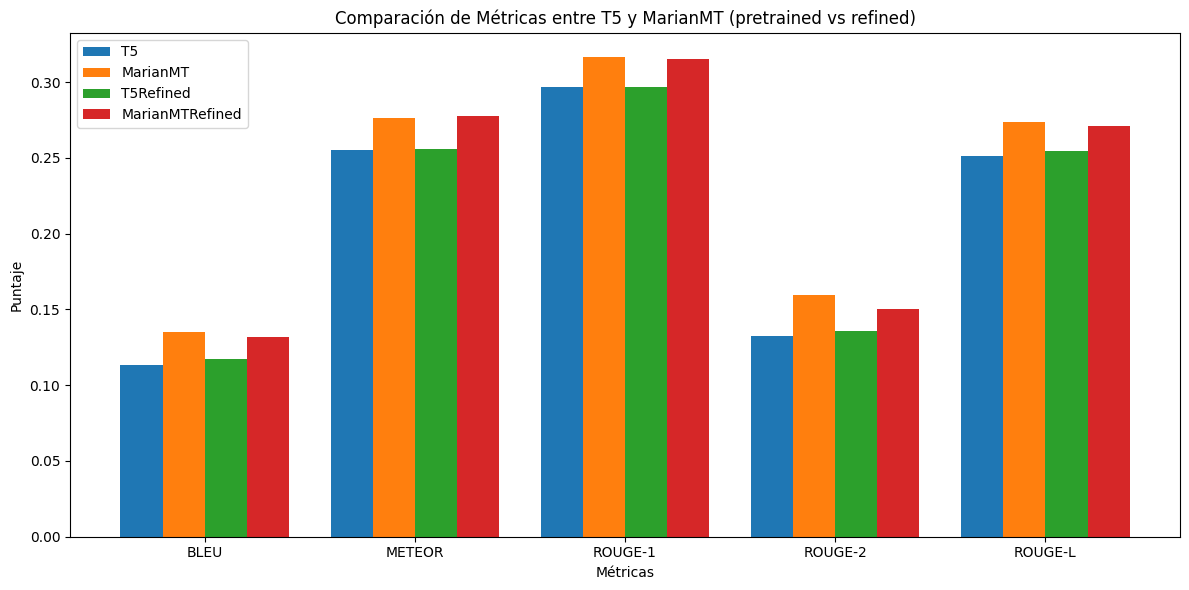

In [11]:
import matplotlib.pyplot as plt
import evaluate


bleu_metric = evaluate.load("bleu")
meteor_metric = evaluate.load("meteor")
rouge_metric = evaluate.load("rouge")


bleu_t5 = bleu_metric.compute(predictions=results['t5'], references=expected_results)
meteor_t5 = meteor_metric.compute(predictions=results['t5'], references=expected_results)
rouge_t5 = rouge_metric.compute(predictions=results['t5'], references=expected_results)

bleu_marian = bleu_metric.compute(predictions=results['marian'], references=expected_results)
meteor_marian = meteor_metric.compute(predictions=results['marian'], references=expected_results)
rouge_marian = rouge_metric.compute(predictions=results['marian'], references=expected_results)


bleu_t5_refined = bleu_metric.compute(predictions=results['t5_refined'], references=expected_results)
meteor_t5_refined = meteor_metric.compute(predictions=results['t5_refined'], references=expected_results)
rouge_t5_refined = rouge_metric.compute(predictions=results['t5_refined'], references=expected_results)

bleu_marian_refined = bleu_metric.compute(predictions=results['marian_refined'], references=expected_results)
meteor_marian_refined = meteor_metric.compute(predictions=results['marian_refined'], references=expected_results)
rouge_marian_refined = rouge_metric.compute(predictions=results['marian_refined'], references=expected_results)



# Sustituye estos valores por los resultados reales
scores_t5 = {
    "BLEU": bleu_t5['bleu'],
    "METEOR": meteor_t5["meteor"],
    "ROUGE-1": rouge_t5["rouge1"],
    "ROUGE-2": rouge_t5["rouge2"],
    "ROUGE-L": rouge_t5["rougeL"]
}

scores_marian = {
    "BLEU": bleu_marian["bleu"],
    "METEOR": meteor_marian["meteor"],
    "ROUGE-1": rouge_marian["rouge1"],
    "ROUGE-2": rouge_marian["rouge2"],
    "ROUGE-L": rouge_marian["rougeL"],
}

scores_t5_refined = {
    "BLEU": bleu_t5_refined['bleu'],
    "METEOR": meteor_t5_refined["meteor"],
    "ROUGE-1": rouge_t5_refined["rouge1"],
    "ROUGE-2": rouge_t5_refined["rouge2"],
    "ROUGE-L": rouge_t5_refined["rougeL"]
}


scores_marian_refined = {
    "BLEU": bleu_marian_refined["bleu"],
    "METEOR": meteor_marian_refined["meteor"],
    "ROUGE-1": rouge_marian_refined["rouge1"],
    "ROUGE-2": rouge_marian_refined["rouge2"],
    "ROUGE-L": rouge_marian_refined["rougeL"],
}


# Crear gráfico
labels = list(scores_t5.keys())
t5_values = list(scores_t5.values())
marian_values = list(scores_marian.values())
t5_values_refined = list(scores_t5_refined.values())
marian_values_refined = list(scores_marian_refined.values())

x = range(len(labels))
bar_width = 0.2  # Reducimos el ancho de las barras para que estén más juntas

plt.figure(figsize=(12, 6))
plt.bar([i - bar_width * 1.5 for i in x], t5_values, width=bar_width, label="T5", align="center")
plt.bar([i - bar_width * 0.5 for i in x], marian_values, width=bar_width, label="MarianMT", align="center")
plt.bar([i + bar_width * 0.5 for i in x], t5_values_refined, width=bar_width, label="T5Refined", align="center")
plt.bar([i + bar_width * 1.5 for i in x], marian_values_refined, width=bar_width, label="MarianMTRefined", align="center")

# Configurar etiquetas y leyenda
plt.xticks(x, labels)
plt.xlabel("Métricas")
plt.ylabel("Puntaje")
plt.title("Comparación de Métricas entre T5 y MarianMT (pretrained vs refined)")
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

#### Tarea MB7 comentar los resultados obtenidos
¿Cómo es eso posible? ¿En que puede influenciar el dataset utilizado?

## Modelos sin entrenamiento previo (tabula rasa)



Para utilizar modelos sin entrenamiento previo, o bien disponemos de uno existente que no haya sido entrenado, o en nuestro caso tenemos que resetear los pesos internos de los modelos generando una configuración nueva incial del encoder y decoder.

### Entrenando un modelo MarianMt desde 0

In [12]:
from transformers import MarianMTModel, MarianTokenizer, MarianConfig

# Crear configuración para un modelo Marian en blanco
config = MarianConfig(
    vocab_size=32000,  # Tamaño del vocabulario (ajústalo según tu caso)
    max_position_embeddings=512,
    encoder_layers=6,
    decoder_layers=6,
    encoder_attention_heads=8,
    decoder_attention_heads=8,
    d_model=512,
    d_ff=2048,
    dropout=0.1,
    pad_token_id=0,
    eos_token_id=1,
    bos_token_id=2,
)

# Crear el modelo MarianMT desde cero
marian_model_trained = MarianMTModel(config)

# Crear un tokenizador vacío
marian_tokenizer_trained = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
marian_model_trained.resize_token_embeddings(len(marian_tokenizer_trained))

# Guardamos el modelo
marian_model_trained.save_pretrained("./models/trained-marian-en-es")
marian_tokenizer_trained.save_pretrained("./models/trained-marian-en-es")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


('./models/trained-marian-en-es/tokenizer_config.json',
 './models/trained-marian-en-es/special_tokens_map.json',
 './models/trained-marian-en-es/vocab.json',
 './models/trained-marian-en-es/source.spm',
 './models/trained-marian-en-es/target.spm',
 './models/trained-marian-en-es/added_tokens.json')

A continuación vamos a probar a usar el modelo guardado

In [13]:
marian_model_trained = MarianMT(model_name="./models/trained-marian-en-es", cache_dir="./models/trained-marian-en-es")

texts = ["On the table, there were a good number of topics", "manners maketh the man"]
translated_text = marian_model_trained.translate_batch(texts)
print(">T5 refined: ", translated_text)

>T5 refined:  ['ãùãÞ Gla Pacto disfrutar Multi Multitir Marthadragon compacto1998 injection injectionagency Gene Hispanic youth extradition extradition extradition theme enfrentar enfrentar planets planets planets humanitaria causadas 45 planets Roger Roger Roger letras letras enfrentar letras concludes concludes pot enfrentar enfrentar enfrentar enfrentar enfrentar enfrentar enfrentar enfrentar enfrentar enfrentar enfrentar enfrentar analytical beneficiaries pot Athens Athensdiscriminatory mon mon mon22 Formas2222discriminatory swap enfrentar enfrentar enfrentar consorcio consorcio FAOWHOWHO Upper comentarios Canta estamosIvoire2222 disminuirtrip Sport Sport Kol Kol Kol\u0e0022 called called called called called called called called called called called called FAO FAO frequentref instrucción called1.0 called called called called called called delitos\u0e00 Impuestos Impuestos Impuestos Alicia Aliciaadas delitos delitos movilidad Alicia Alicia [1] [1] [1] [1] [1] [1] [1] [1] [1] delito

Como vemos el resultado ya no es algo coherente, ahora vamos a proceder a entrenarlo.

#### Generando un nuevo modelo "tabula rasa"

In [14]:
def load_trained_marian():
    marian_model = MarianMTModel.from_pretrained("./models/trained-marian-en-es")
    marian_tokenizer = MarianTokenizer.from_pretrained("./models/trained-marian-en-es")
    return marian_model, marian_tokenizer


#### Entrenando el modelo

In [15]:
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    output_dir="./models/training/trained-marian-en-es",
    eval_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=10,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=100,
    logging_dir='./logs',
    report_to="none"
)

# Descarga y división del dataset
#dataset = load_dataset("Iker/Document-Translation-en-es", split="train", cache_dir="./data/iker")
#split_dataset = dataset.train_test_split(train_size=1000, test_size=50)
#train_dataset = split_dataset["train"]
#eval_dataset = split_dataset["test"]

# Carga del modelo baseline
marian_model_trained, marian_tokenizer_trained = load_trained_marian()

def preprocess_function(examples):
    global marian_tokenizer_trained
    inputs_lang = examples['en']
    targets_lang =  examples['es']

    model_inputs = marian_tokenizer_trained(inputs_lang, text_target=targets_lang, max_length=128, truncation=True, padding="max_length")
    return model_inputs

# Preparación de los datos para evaluación y entrenamiento
encoded_training_dataset = train_dataset.map(preprocess_function, batched=True)
encoded_eval_dataset = eval_dataset.map(preprocess_function, batched=True)

# Preparar el Trainer
collator = DataCollatorForSeq2Seq(tokenizer=marian_tokenizer_trained, model=marian_model_trained)
trainer = Trainer(
    model=marian_model_trained,
    args=training_args,
    train_dataset=encoded_training_dataset,
    eval_dataset=encoded_eval_dataset,
    data_collator= collator
)

# Refinar el modelo
trainer.train()

# Guardar el modelo y el tokenizador después del entrenamiento
marian_model_trained.save_pretrained("./models/trained-marian-en-es")
marian_tokenizer_trained.save_pretrained("./models/trained-marian-en-es")


Epoch,Training Loss,Validation Loss
1,No log,8.137140
2,No log,7.611825
3,No log,7.693851
4,8.662000,7.889685
5,8.662000,7.987017


('./models/trained-marian-en-es/tokenizer_config.json',
 './models/trained-marian-en-es/special_tokens_map.json',
 './models/trained-marian-en-es/vocab.json',
 './models/trained-marian-en-es/added_tokens.json')

Una vez más, probamos el modelo:

In [16]:
marian_model_trained = MarianMT(model_name="./models/trained-marian-en-es", cache_dir="./models/trained-marian-en-es")

texts = ["On the table, there were a good number of topics", "manners maketh the man"]
translated_text = marian_model_trained.translate_batch(texts)
print(">T5 refined: ", translated_text)

>T5 refined:  ['ãùãÞ de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de, de de de de de de de de, de de de de de de de de, de de de de de de de de de de de de de de de de de de de de de de de de de, de de de de de de de de de de de de,, de de de de de de, de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de', 'ãùãÞ de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de, de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de de la de de de de de de de de de de de de de de de de de de de de de de de de de, de de de de de, de de de de de de de de de de, de de de de de de, de de de de de de, d

### Entrenando un modelo T5 desde 0

#### Generando un nuevo modelo "tabula rasa"

In [17]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config

# Crear configuración para un modelo T5 en blanco
config = T5Config(
    vocab_size=32000,
    d_model=512,
    d_ff=2048,
    num_layers=6,
    num_heads=8,
    dropout_rate=0.1,
    pad_token_id=0,  # Token de padding
    eos_token_id=1,  # Token de fin de secuencia
    decoder_start_token_id=0,  # Token de inicio del decodificador
)

t5_model_trained = T5ForConditionalGeneration(config)

t5_tokenizer_trained = T5Tokenizer.from_pretrained("vgaraujov/t5-base-translation-en-es")

t5_model_trained.save_pretrained("./models/trained-t5-en-es")
t5_tokenizer_trained.save_pretrained("./models/trained-t5-en-es")

def load_trained_t5():
    t5_model = T5ForConditionalGeneration.from_pretrained("./models/trained-t5-en-es")
    t5_tokenizer = T5Tokenizer.from_pretrained("./models/trained-t5-en-es")
    return t5_model, t5_tokenizer


#### Entrenando el modelo

#### Tarea MB8

Completar el siguiente código para entrenar el modelo T5

In [18]:
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    output_dir="./models/training/trained-t5-en-es",
    eval_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=10,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=100,
    logging_dir='./logs',
    report_to="none"
)

'''
# Descarga y división del dataset
dataset = load_dataset("Iker/Document-Translation-en-es", split="train", cache_dir="./data/iker")
split_dataset = dataset.train_test_split(train_size=1000, test_size=50)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]
'''

# Carga del modelo baseline
t5_model_trained, t5_tokenizer_trained = load_trained_t5()

def preprocess_function(examples):
    global t5_tokenizer_trained
    inputs_lang = examples['en']
    targets_lang =  examples['es']

    model_inputs = t5_tokenizer_trained(inputs_lang, text_target=targets_lang, max_length=128, truncation=True, padding="max_length")
    return model_inputs

# Preparación de los datos para evaluación y entrenamiento
encoded_training_dataset = train_dataset.map(preprocess_function, batched=True)
encoded_eval_dataset = eval_dataset.map(preprocess_function, batched=True)

# Preparar el Trainer
collator = DataCollatorForSeq2Seq(tokenizer=t5_tokenizer_trained, model=t5_model_trained)
trainer = Trainer(
    model=t5_model_trained,
    args=training_args,
    train_dataset=encoded_training_dataset,
    eval_dataset=encoded_eval_dataset,
    data_collator= collator
)

# Refinar el modelo
trainer.train()

# Guardar el modelo y el tokenizador después del entrenamiento
t5_model_trained.save_pretrained("./models/trained-t5-en-es")
t5_tokenizer_trained.save_pretrained("./models/trained-t5-en-es")


Using the latest cached version of the dataset since Iker/Document-Translation-en-es couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at data/iker/Iker___document-translation-en-es/default/0.0.0/4f6ede8020b7c03ea59c348df00e028f66ba82a0 (last modified on Sun Jan 19 18:04:06 2025).


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,No log,8.653187
2,No log,8.375385
3,No log,8.273010
4,8.500100,8.206021
5,8.500100,8.185229


('./models/trained-t5-en-es/tokenizer_config.json',
 './models/trained-t5-en-es/special_tokens_map.json',
 './models/trained-t5-en-es/spiece.model',
 './models/trained-t5-en-es/added_tokens.json')

Probamos el modelo entrenado:

In [21]:
t5_model_trained = T5MT(model_name="./models/trained-t5-en-es", cache_dir="./models/trained-t5-en-es")

texts = ["On the table, there were a good number of topics", "manners maketh the man"]
translated_text = t5_model_trained.translate_batch(texts)
print(">T5 refined: ", translated_text)

>T5 refined:  ['El de la. El El. El El. El. El El. El del del del del del del del del del del del del del del del del del del del del del del del del del la que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el', 'El de la. El El El El El. El. El. El. El. El El El de la que el que el que el que el que el que el que el que el que se ha ha ha ha ha ha ha que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el que el

### Evaluando todos los modelos

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/andreacimmino/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


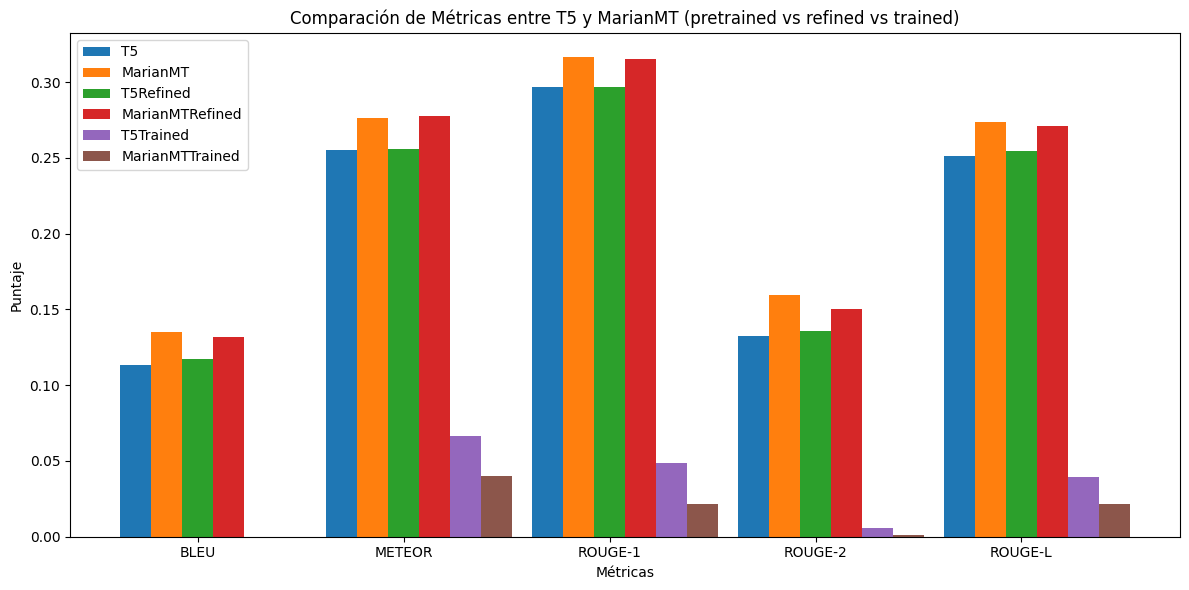

In [22]:
import matplotlib.pyplot as plt

t5_trained_results = t5_model_trained.translate_batch(inputs)
marianmt_trained_results = marian_model_trained.translate_batch(inputs)

bleu_metric = evaluate.load("bleu")
meteor_metric = evaluate.load("meteor")
rouge_metric = evaluate.load("rouge")

bleu_t5_trained = bleu_metric.compute(predictions=t5_trained_results, references=expected_results)
meteor_t5_trained = meteor_metric.compute(predictions=t5_trained_results, references=expected_results)
rouge_t5_trained = rouge_metric.compute(predictions=t5_trained_results, references=expected_results)

bleu_marian_trained = bleu_metric.compute(predictions=marianmt_trained_results, references=expected_results)
meteor_marian_trained = meteor_metric.compute(predictions=marianmt_trained_results, references=expected_results)
rouge_marian_trained = rouge_metric.compute(predictions=marianmt_trained_results, references=expected_results)

# Sustituye estos valores por los resultados reales
scores_t5 = {
    "BLEU": bleu_t5['bleu'],
    "METEOR": meteor_t5["meteor"],
    "ROUGE-1": rouge_t5["rouge1"],
    "ROUGE-2": rouge_t5["rouge2"],
    "ROUGE-L": rouge_t5["rougeL"]
}

scores_marian = {
    "BLEU": bleu_marian["bleu"],
    "METEOR": meteor_marian["meteor"],
    "ROUGE-1": rouge_marian["rouge1"],
    "ROUGE-2": rouge_marian["rouge2"],
    "ROUGE-L": rouge_marian["rougeL"],
}

scores_t5_refined = {
    "BLEU": bleu_t5_refined['bleu'],
    "METEOR": meteor_t5_refined["meteor"],
    "ROUGE-1": rouge_t5_refined["rouge1"],
    "ROUGE-2": rouge_t5_refined["rouge2"],
    "ROUGE-L": rouge_t5_refined["rougeL"]
}


scores_marian_refined = {
    "BLEU": bleu_marian_refined["bleu"],
    "METEOR": meteor_marian_refined["meteor"],
    "ROUGE-1": rouge_marian_refined["rouge1"],
    "ROUGE-2": rouge_marian_refined["rouge2"],
    "ROUGE-L": rouge_marian_refined["rougeL"],
}

scores_t5_trained = {
    "BLEU": bleu_t5_trained['bleu'],
    "METEOR": meteor_t5_trained["meteor"],
    "ROUGE-1": rouge_t5_trained["rouge1"],
    "ROUGE-2": rouge_t5_trained["rouge2"],
    "ROUGE-L": rouge_t5_trained["rougeL"]
}


scores_marian_trained = {
    "BLEU": bleu_marian_trained["bleu"],
    "METEOR": meteor_marian_trained["meteor"],
    "ROUGE-1": rouge_marian_trained["rouge1"],
    "ROUGE-2": rouge_marian_trained["rouge2"],
    "ROUGE-L": rouge_marian_trained["rougeL"],
}


# Crear gráfico
labels = list(scores_t5.keys())
t5_values = list(scores_t5.values())
marian_values = list(scores_marian.values())
t5_values_refined = list(scores_t5_refined.values())
marian_values_refined = list(scores_marian_refined.values())
t5_values_trained = list(scores_t5_trained.values())
marian_values_trained= list(scores_marian_trained.values())

x = range(len(labels))
bar_width = 0.15  # Ajustar el ancho de las barras

# Crear gráfico
plt.figure(figsize=(12, 6))

plt.bar([i - 2 * bar_width for i in x], t5_values, width=bar_width, label="T5")
plt.bar([i - bar_width for i in x], marian_values, width=bar_width, label="MarianMT")
plt.bar(x, t5_values_refined, width=bar_width, label="T5Refined")
plt.bar([i + bar_width for i in x], marian_values_refined, width=bar_width, label="MarianMTRefined")
plt.bar([i + 2 * bar_width for i in x], t5_values_trained, width=bar_width, label="T5Trained")
plt.bar([i + 3 * bar_width for i in x], marian_values_trained, width=bar_width, label="MarianMTTrained")

# Configurar etiquetas y leyenda
plt.xticks(x, labels)
plt.xlabel("Métricas")
plt.ylabel("Puntaje")
plt.title("Comparación de Métricas entre T5 y MarianMT (pretrained vs refined vs trained)")
plt.legend()
plt.tight_layout()

plt.show()

#### Tarea MB9
Comentar los resultados obtenidos, ¿Por qué los modelos entrenados no tienen un buen *performance*? ¿Puede un modelo mal entrenado obtener resultados evaluables?